In [1]:
import os
import time
import glob
import re
import pandas as pd
from functools import reduce
from klepto.archives import dir_archive

import numpy as np
from tqdm.auto import tqdm
import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea.analysis_objects import JaggedCandidateArray
from coffea.btag_tools import BTagScaleFactor
from coffea import hist
import pandas as pd
import uproot_methods
import uproot
import awkward
import copy

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from Tools.config_helpers import *
from Tools.helpers import mergeArray, mt, get_scheduler_address

from Tools.objects import Collections
from Tools.cutflow import Cutflow

from Tools.WH_objects import *

# This just tells matplotlib not to open any
# interactive windows.
matplotlib.use('Agg')

In [2]:
def pad_and_flatten(val): 
    try:
        return val.pad(1, clip=True).fillna(0.).flatten()#.reshape(-1, 1)
    except AttributeError:
        return val.flatten()

#os.environ['KERAS_BACKEND'] = 'theano'
#from keras.models import load_model

In [3]:
import sys
sys.setrecursionlimit(10000)
print(sys.getrecursionlimit())

10000


In [4]:
#global variables... to avoid making bugs!!!
processesList = ['mC750_l1', 'WJets', 'TTJets', 'ST', 'ttW', 'WW', 'ZNuNu', 'QCD', 'Data']
linesList= ['filters', 'triggers', 'stitch','skim', 'Exactly 1 e or mu',  'MET>250', 'N_fatjet>1', 'min_dphiFatJetMet4', 'dphiDiFatJet', 'minmth>200', 'njet veto', 'N_wtag>0', 'N_htag>0', 'N_wtag>0, N_wtag>0']

In [5]:
class analysisProcessor(processor.ProcessorABC):
    """Processor used for running the analysis"""
    def __init__(self):
        
        ## load b-tag SFs
        #self.btag_sf = BTagScaleFactor(os.path.expandvars("$TWHOME/data/DeepCSV_102XSF_V1.btag.csv.gz", "reshape")

        ## load the NN
        #self.model = load_model('../ML/data/training.h5')
        #self.stds  = pd.read_json('../ML/data/stds.json').squeeze()
        #self.means = pd.read_json('../ML/data/means.json').squeeze()
        
        # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset",   "Primary dataset")
        pt_axis             = hist.Bin("pt",        r"$p_{T}$ (GeV)", 1000, 0, 1000)
        p_axis              = hist.Bin("p",         r"$p$ (GeV)", 1000, 0, 2500)
        ht_axis             = hist.Bin("ht",        r"$H_{T}$ (GeV)", 500, 0, 5000)
        mass_axis           = hist.Bin("mass",      r"M (GeV)", 1000, 0, 2000)
        eta_axis            = hist.Bin("eta",       r"$\eta$", 60, -5.5, 5.5)
        delta_axis          = hist.Bin("delta",     r"$\delta$", 100,0,10 )
        multiplicity_axis   = hist.Bin("multiplicity",         r"N", 20, -0.5, 19.5)
        norm_axis           = hist.Bin("norm",         r"N", 25, 0, 1)

        self._accumulator = processor.dict_accumulator({
            #"MET_pt_baseline" :          hist.Hist("Counts", dataset_axis, pt_axis),
            #"HT_baseline" :              hist.Hist("Counts", dataset_axis, ht_axis),
            #"mtb_min_baseline" :         hist.Hist("Counts", dataset_axis, mass_axis),
            #"MET_pt" :          hist.Hist("Counts", dataset_axis, pt_axis),
            #"HT" :              hist.Hist("Counts", dataset_axis, ht_axis),
            #"mtb_min" :         hist.Hist("Counts", dataset_axis, mass_axis),
            #"MET_pt_CR" :       hist.Hist("Counts", dataset_axis, pt_axis),
            #"HT_CR" :           hist.Hist("Counts", dataset_axis, ht_axis),
            #"mtb_min_CR" :      hist.Hist("Counts", dataset_axis, mass_axis),
            #"lead_AK8_pt" :     hist.Hist("Counts", dataset_axis, pt_axis),
            #"W_pt" :            hist.Hist("Counts", dataset_axis, pt_axis),
            #"H_pt" :            hist.Hist("Counts", dataset_axis, pt_axis),
            #"W_eta" :           hist.Hist("Counts", dataset_axis, eta_axis),
            #"H_eta" :           hist.Hist("Counts", dataset_axis, eta_axis),
            
            "met_CR":           hist.Hist("Counts", dataset_axis, pt_axis),
            "met_Higgs_CR":     hist.Hist("Counts", dataset_axis, pt_axis),
            "met_W_CR":         hist.Hist("Counts", dataset_axis, pt_axis),
            "met_Higgs_W_CR":   hist.Hist("Counts", dataset_axis, pt_axis),
            
            "ht_CR":            hist.Hist("Counts", dataset_axis, ht_axis),
            "ht_Higgs_CR":      hist.Hist("Counts", dataset_axis, ht_axis),
            "ht_W_CR":          hist.Hist("Counts", dataset_axis, ht_axis),
            "ht_Higgs_W_CR":    hist.Hist("Counts", dataset_axis, ht_axis),
            
            "N_AK8_CR" :        hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "W_pt_CR" :         hist.Hist("Counts", dataset_axis, pt_axis),
            "H_pt_CR" :         hist.Hist("Counts", dataset_axis, pt_axis),
            "W_eta_CR" :        hist.Hist("Counts", dataset_axis, eta_axis),
            "H_eta_CR" :        hist.Hist("Counts", dataset_axis, eta_axis),
            
            "N_AK8_Higgs_CR" :  hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "W_pt_Higgs_CR" :   hist.Hist("Counts", dataset_axis, pt_axis),
            "H_pt_Higgs_CR" :   hist.Hist("Counts", dataset_axis, pt_axis),
            "W_eta_Higgs_CR" :  hist.Hist("Counts", dataset_axis, eta_axis),
            "H_eta_Higgs_CR" :  hist.Hist("Counts", dataset_axis, eta_axis),
            
            "N_AK8_W_CR" :      hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "W_pt_W_CR" :       hist.Hist("Counts", dataset_axis, pt_axis),
            "H_pt_W_CR" :       hist.Hist("Counts", dataset_axis, pt_axis),
            "W_eta_W_CR" :      hist.Hist("Counts", dataset_axis, eta_axis),
            "H_eta_W_CR" :      hist.Hist("Counts", dataset_axis, eta_axis),
            
            "N_AK8_Higgs_W_CR" :hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "W_pt_Higgs_W_CR" : hist.Hist("Counts", dataset_axis, pt_axis),
            "H_pt_Higgs_W_CR" : hist.Hist("Counts", dataset_axis, pt_axis),
            "W_eta_Higgs_W_CR" :hist.Hist("Counts", dataset_axis, eta_axis),
            "H_eta_Higgs_W_CR" :hist.Hist("Counts", dataset_axis, eta_axis),
            
            "lead_AK8_pt" :     hist.Hist("Counts", dataset_axis, pt_axis),
            "sublead_AK8_pt" :  hist.Hist("Counts", dataset_axis, pt_axis),
            "lead_AK8_eta" :    hist.Hist("Counts", dataset_axis, eta_axis),
            "sublead_AK8_eta" : hist.Hist("Counts", dataset_axis, eta_axis),
            "lead_AK8_mass" :   hist.Hist("Counts", dataset_axis, mass_axis),
            "sublead_AK8_mass" : hist.Hist("Counts", dataset_axis, mass_axis),
            "N_W_CR" :          hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_H_CR" :          hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_AK4_CR" :        hist.Hist("Counts", dataset_axis, multiplicity_axis),


            #"N_b" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            #"N_AK4" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            #"N_AK8" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            #"N_H" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            #"N_W" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            
            #"WH_deltaPhi":      hist.Hist("Counts", dataset_axis, delta_axis),
            #"WH_deltaR":        hist.Hist("Counts", dataset_axis, delta_axis),
            #"bb_deltaPhi":      hist.Hist("Counts", dataset_axis, delta_axis),
            #"bb_deltaR":        hist.Hist("Counts", dataset_axis, delta_axis),
            #"min_dphiJetMet4":  hist.Hist("Counts", dataset_axis, delta_axis),
            #"dphiDiJet":        hist.Hist("Counts", dataset_axis, delta_axis),
            #"dphiDiFatJet":     hist.Hist("Counts", dataset_axis, delta_axis),
            
            'mC750_l1':         processor.defaultdict_accumulator(int),
            'WJets':            processor.defaultdict_accumulator(int),
            'QCD':              processor.defaultdict_accumulator(int),
            'TTJets':           processor.defaultdict_accumulator(int),
            'ZNuNu':            processor.defaultdict_accumulator(int),
            'ST':               processor.defaultdict_accumulator(int),
            'ST_tW':            processor.defaultdict_accumulator(int),
            'ST_tChannel':      processor.defaultdict_accumulator(int),
            'ST_sChannel':      processor.defaultdict_accumulator(int),
            'ttW':              processor.defaultdict_accumulator(int),
            'ttZ':              processor.defaultdict_accumulator(int),
            'WW':               processor.defaultdict_accumulator(int),
            'WZ/ZZ':            processor.defaultdict_accumulator(int),
            'LL':               processor.defaultdict_accumulator(int),
            'Data':             processor.defaultdict_accumulator(int),
            'totalEvents':      processor.defaultdict_accumulator(int),
            'test1':            processor.defaultdict_accumulator(float),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        dataset = df["dataset"]
        cfg = loadConfig()
        
        ## MET -> can switch to puppi MET
        met_pt  = df["MET_pt"]
        met_phi = df["MET_phi"]
        
        ## Load Objects
        muon     = getMuons(df, WP='veto')
        electron = getElectrons(df, WP='veto')
        fatjet   = getFatJets(df)
        jet      = getJets(df)
        triggers = getTriggers(df, year=2018, dataset=dataset) #hard-coding the year since I'm only looking at one, will need to change!!!!!
        filters  = getFilters(df, year=2018, dataset=dataset) #hard-coding the year since I'm only looking at one, will need to change!!!!!
        
        ## Clean Objects
        skimjet   = jet[(jet.pt>30) & (abs(jet.eta)<2.4)]
        jet       = jet[(jet.pt>30) & (jet.jetId>1) & (abs(jet.eta)<2.4)]
        jet       = jet[~jet.match(muon, deltaRCut=0.4)] # remove jets that overlap with muons
        jet       = jet[~jet.match(electron, deltaRCut=0.4)] # remove jets that overlap with electrons
        jet       = jet[~jet.match(fatjet, deltaRCut=1.2)] # remove AK4 jets that overlap with AK8 jets
        jet       = jet[jet.pt.argsort(ascending=False)] # sort the jets
        btag      = jet[(jet.btagDeepB>0.4184)]
        light     = jet[(jet.btagDeepB<0.4184)]
        
        ## Calculating Variables
        
        ## FatJet Variables
        leadFatJet = fatjet[:,:1]
        leadingFatJets = fatjet[:,:2]
        difatjet = leadingFatJets.choose(2)
        subleadFatJet = leadingFatJets[leadingFatJets.pt.argmin()]
        dphiDiFatJet = np.arccos(np.cos(difatjet.i0.phi-difatjet.i1.phi))
        
        ## H-tagged Variables
        htag = fatjet[((fatjet.pt > 200) & (fatjet.deepTagMD_HbbvsQCD > 0.8365))]
        htag_hard = fatjet[((fatjet.pt > 300) & (fatjet.deepTagMD_HbbvsQCD > 0.8365))]
        
        lead_htag = htag[htag.pt.argmax()]
        
        ## W-tagged Variables
        wtag = fatjet[((fatjet.pt > 200) & (fatjet.deepTagMD_HbbvsQCD < 0.8365) & (fatjet.deepTag_WvsQCD > 0.918))]
        wtag_hard = fatjet[((fatjet.pt > 300) & (fatjet.deepTagMD_HbbvsQCD < 0.8365) & (fatjet.deepTag_WvsQCD > 0.918))]
        
        lead_wtag = wtag[wtag.pt.argmax()]
        
        ## W, H tagged variables
        wh = lead_htag.cross(lead_wtag)
        wh_deltaPhi = np.arccos(wh.i0.phi - wh.i1.phi)
        wh_deltaR = wh.i0.p4.delta_r(wh.i1.p4)
        
        ## b-tagged variables
        high_score_btag = jet[jet.btagDeepB.argsort(ascending=False)][:,:2]
        
        leading_jet    = jet[jet.pt.argmax()]
        leading_b      = btag[btag.pt.argmax()]
        
        bb = high_score_btag.choose(2)
        bb_deltaPhi = np.arccos(np.cos(bb.i0.phi-bb.i1.phi))
        bb_deltaR = bb.i0.p4.delta_r(bb.i1.p4)
        
        ## mt variabels
        mtb = mt(btag.pt, btag.phi, met_pt, met_phi)
        min_mtb = mtb.min()
        mth = mt(htag.pt, htag.phi, met_pt, met_phi)

        ## other variables
        ht = jet.pt.sum()
        
        min_dphiJetMet4 = np.arccos(np.cos(jet[:,:4].phi-met_phi)).min()
        
        leadingJets = jet[:,:2]
        dijet = leadingJets.choose(2)
        dphiDiJet = np.arccos(np.cos(dijet.i0.phi-dijet.i1.phi))
        
        min_dphiFatJetMet4 = np.arccos(np.cos(fatjet[:,:4].phi-met_phi)).min()

        ## variables for selections       
        wtag_sel = ( wtag.counts>0 & (abs(wtag.msoftdrop-80)<30).any())
        htag_sel = ( htag.counts>0 & (abs(htag.msoftdrop-125)<25).any())
        stitchVar = 1 if dataset=='Data' else df["stitch"]
        
        ## define selections (maybe move to a different file at some point)
        
        output['totalEvents']['all'] += len(df['weight'])
        
        # Cutflow
        processes = processesList
        weight = np.ones(len(df['weight'])) if dataset=='Data' else df['weight']
        lumi = 1 if dataset=='Data' else 60
        fullweight = weight * lumi
        
        cutflow = Cutflow(output, df, cfg, processes, weight=fullweight)
        
        cutflow.addRow( 'filters',   (filters==1) )
        cutflow.addRow( 'triggers',   (triggers==1) )
        
        cutflow.addRow( 'stitch',   (stitchVar ==1) )
        
        cutflow.addRow( 'skim',   ((met_pt>200) & (skimjet.counts>1)) )
        cutflow.addRow( 'Exactly 1 e or mu',   ((electron.counts+muon.counts)==1) )
        cutflow.addRow( 'MET>250',     (met_pt>250) )
        
        baseline = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'N_fatjet>1',      (fatjet.counts>1) )
        cutflow.addRow( 'min_dphiFatJetMet4', (min_dphiFatJetMet4>0.5))
        cutflow.addRow( 'dphiDiFatJet', (dphiDiFatJet<2.5).all() ) # by using .all() I do not implicitely cut on the number of fat jets
        cutflow.addRow( 'minmth>200',   (mth.min()>200) )
        cutflow.addRow( 'njet veto',     (jet.counts<2))

        vetoQCD = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'N_wtag>0',     (wtag_sel), cumulative=False)
        
        wtag_selection = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'N_htag>0',     (htag_sel), cumulative=False)

        htag_selection = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'N_htag>0, N_wtag>0',     (htag_sel & wtag_sel))

        signal_selection = cutflow.selection
        
        ### And fill the histograms
        output['met_CR'].fill(dataset=dataset, pt=met_pt[vetoQCD].flatten(), weight=fullweight[vetoQCD])
        output['met_W_CR'].fill(dataset=dataset, pt=met_pt[vetoQCD & wtag_sel].flatten(), weight=fullweight[vetoQCD & wtag_sel])
        output['met_Higgs_CR'].fill(dataset=dataset, pt=met_pt[vetoQCD & htag_sel].flatten(), weight=fullweight[vetoQCD & htag_sel])
        output['met_Higgs_W_CR'].fill(dataset=dataset, pt=met_pt[signal_selection].flatten(), weight=fullweight[signal_selection])

        output['ht_CR'].fill(dataset=dataset, ht=ht[vetoQCD].flatten(), weight=fullweight[vetoQCD])
        output['ht_W_CR'].fill(dataset=dataset, ht=ht[vetoQCD & wtag_sel].flatten(), weight=fullweight[vetoQCD & wtag_sel])
        output['ht_Higgs_CR'].fill(dataset=dataset, ht=ht[vetoQCD & htag_sel].flatten(), weight=fullweight[vetoQCD & htag_sel])
        output['ht_Higgs_W_CR'].fill(dataset=dataset, ht=ht[signal_selection].flatten(), weight=fullweight[signal_selection])
        
        output['N_AK8_CR'].fill(dataset=dataset, multiplicity=fatjet[vetoQCD].counts, weight=fullweight[vetoQCD])
        #output['W_pt_CR'].fill(dataset=dataset, pt=lead_wtag[vetoQCD].pt.flatten(), weight=fullweight[vetoQCD])
        #output['H_pt_CR'].fill(dataset=dataset, pt=lead_htag[vetoQCD].pt.flatten(), weight=fullweight[vetoQCD])
        #output['W_eta_CR'].fill(dataset=dataset, eta=lead_wtag[vetoQCD].eta.flatten(), weight=fullweight[vetoQCD])
        #output['H_eta_CR'].fill(dataset=dataset, eta=lead_htag[vetoQCD].eta.flatten(), weight=fullweight[vetoQCD])

        output['lead_AK8_pt'].fill(dataset=dataset, pt=leadFatJet[vetoQCD].pt.flatten(), weight=fullweight[vetoQCD])
        output['sublead_AK8_pt'].fill(dataset=dataset, pt=subleadFatJet[vetoQCD].pt.flatten(), weight=fullweight[vetoQCD])
        output['lead_AK8_eta'].fill(dataset=dataset, eta=leadFatJet[vetoQCD].eta.flatten(), weight=fullweight[vetoQCD])
        output['sublead_AK8_eta'].fill(dataset=dataset, eta=subleadFatJet[vetoQCD].eta.flatten(), weight=fullweight[vetoQCD])
        output['lead_AK8_mass'].fill(dataset=dataset, mass=leadFatJet[vetoQCD].msoftdrop.flatten(), weight=fullweight[vetoQCD])
        output['sublead_AK8_mass'].fill(dataset=dataset, mass=subleadFatJet[vetoQCD].msoftdrop.flatten(), weight=fullweight[vetoQCD])
        output['N_W_CR'].fill(dataset=dataset, multiplicity=wtag[vetoQCD].counts, weight=fullweight[vetoQCD])
        output['N_H_CR'].fill(dataset=dataset, multiplicity=htag[vetoQCD].counts, weight=fullweight[vetoQCD])
        output['N_AK4_CR'].fill(dataset=dataset, multiplicity=jet[vetoQCD].counts, weight=fullweight[vetoQCD])
                
        output['N_AK8_W_CR'].fill(dataset=dataset, multiplicity=fatjet[vetoQCD & wtag_sel].counts, weight=fullweight[vetoQCD & wtag_sel])
        output['W_pt_W_CR'].fill(dataset=dataset, pt=lead_wtag[vetoQCD & wtag_sel].pt.flatten(), weight=fullweight[vetoQCD & wtag_sel])
        #output['H_pt_W_CR'].fill(dataset=dataset, pt=lead_htag[vetoQCD & wtag_sel].pt.flatten(), weight=fullweight[vetoQCD & wtag_sel])
        output['W_eta_W_CR'].fill(dataset=dataset, eta=lead_wtag[vetoQCD & wtag_sel].eta.flatten(), weight=fullweight[vetoQCD & wtag_sel])
        #output['H_eta_W_CR'].fill(dataset=dataset, eta=lead_htag[vetoQCD & wtag_sel].eta.flatten(), weight=fullweight[vetoQCD & wtag_sel])

        output['N_AK8_Higgs_CR'].fill(dataset=dataset, multiplicity=fatjet[vetoQCD & htag_sel].counts, weight=fullweight[vetoQCD & htag_sel])
        #output['W_pt_Higgs_CR'].fill(dataset=dataset, pt=lead_wtag[vetoQCD & htag_sel].pt.flatten(), weight=fullweight[vetoQCD & htag_sel])
        output['H_pt_Higgs_CR'].fill(dataset=dataset, pt=lead_htag[vetoQCD & htag_sel].pt.flatten(), weight=fullweight[vetoQCD & htag_sel])
        #output['W_eta_Higgs_CR'].fill(dataset=dataset, eta=lead_wtag[vetoQCD & htag_sel].eta.flatten(), weight=fullweight[vetoQCD & htag_sel])
        output['H_eta_Higgs_CR'].fill(dataset=dataset, eta=lead_htag[vetoQCD & htag_sel].eta.flatten(), weight=fullweight[vetoQCD & htag_sel])

        output['N_AK8_Higgs_W_CR'].fill(dataset=dataset, multiplicity=fatjet[signal_selection].counts, weight=fullweight[signal_selection])
        output['W_pt_Higgs_W_CR'].fill(dataset=dataset, pt=lead_wtag[signal_selection].pt.flatten(), weight=fullweight[signal_selection])
        output['H_pt_Higgs_W_CR'].fill(dataset=dataset, pt=lead_htag[signal_selection].pt.flatten(), weight=fullweight[signal_selection])
        output['W_eta_Higgs_W_CR'].fill(dataset=dataset, eta=lead_wtag[signal_selection].eta.flatten(), weight=fullweight[signal_selection])
        output['H_eta_Higgs_W_CR'].fill(dataset=dataset, eta=lead_htag[signal_selection].eta.flatten(), weight=fullweight[signal_selection])

                
        '''output['MET_pt_baseline'].fill(dataset=dataset, pt=met_pt[baseline].flatten(), weight=df['weight'][baseline]*cfg['lumi'])
        output['HT_baseline'].fill(dataset=dataset, ht=ht[baseline].flatten(), weight=df['weight'][baseline]*cfg['lumi'])
        output['mtb_min_baseline'].fill(dataset=dataset, mass=mtb[baseline].min().flatten(), weight=df['weight'][baseline]*cfg['lumi'])

        output['MET_pt'].fill(dataset=dataset, pt=met_pt[vetoQCD].flatten(), weight=df['weight'][vetoQCD]*cfg['lumi'])
        output['HT'].fill(dataset=dataset, ht=ht[vetoQCD].flatten(), weight=df['weight'][vetoQCD]*cfg['lumi'])
        output['mtb_min'].fill(dataset=dataset, mass=mtb[vetoQCD].min().flatten(), weight=df['weight'][vetoQCD]*cfg['lumi'])
        
        ## N jet and N b without selections on those
        output['N_AK4'].fill(dataset=dataset, multiplicity=jet[baseline].counts, weight=df['weight'][baseline]*cfg['lumi'])
        output['N_b'].fill(dataset=dataset, multiplicity=btag[baseline].counts, weight=df['weight'][baseline]*cfg['lumi'])       
        output['N_W'].fill(dataset=dataset, multiplicity=htag[baseline].counts, weight=df['weight'][baseline]*cfg['lumi'])       
        output['N_H'].fill(dataset=dataset, multiplicity=wtag[baseline].counts, weight=df['weight'][baseline]*cfg['lumi'])       
        output['N_AK8'].fill(dataset=dataset, multiplicity=fatjet[baseline].counts, weight=df['weight'][baseline]*cfg['lumi'])       

        #output['bb_deltaPhi'].fill(dataset=dataset, delta=bb_deltaPhi[baseline].flatten(), weight=df['weight'][baseline]*cfg['lumi'])
        #output['bb_deltaR'].fill(dataset=dataset, delta=bb_deltaR[baseline].flatten(), weight=df['weight'][baseline]*cfg['lumi'])

        output['min_dphiJetMet4'].fill(dataset=dataset, delta=min_dphiJetMet4[baseline].flatten(), weight=df['weight'][baseline]*cfg['lumi'])
        output['dphiDiJet'].fill(dataset=dataset, delta=dphiDiJet[baseline].min().flatten(), weight=df['weight'][baseline]*cfg['lumi'])

        ## Higgs and W pt
        output['lead_AK8_pt'].fill(dataset=dataset, pt=fatjet[(baseline & (fatjet.counts>0))].pt.max().flatten(), weight=df['weight'][(baseline & (fatjet.counts>0))]*cfg['lumi'])
        output['dphiDiFatJet'].fill(dataset=dataset, delta=dphiDiFatJet[(baseline & (fatjet.counts>1))].min().flatten(), weight=df['weight'][(baseline & (fatjet.counts>1))]*cfg['lumi'])

        output['H_pt'].fill(dataset=dataset, pt=lead_htag[event_selection].pt.flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['H_eta'].fill(dataset=dataset, eta=lead_htag[event_selection].eta.flatten(), weight=df['weight'][event_selection]*cfg['lumi'])

        output['W_pt'].fill(dataset=dataset, pt=lead_wtag[event_selection].pt.flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['W_eta'].fill(dataset=dataset, eta=lead_wtag[event_selection].eta.flatten(), weight=df['weight'][event_selection]*cfg['lumi'])

        output['WH_deltaPhi'].fill(dataset=dataset, delta=wh_deltaPhi[event_selection].flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['WH_deltaR'].fill(dataset=dataset, delta=wh_deltaR[event_selection].flatten(), weight=df['weight'][event_selection]*cfg['lumi'])

        output['MET_pt_CR'].fill(dataset=dataset, pt=met_pt[event_selection].flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['HT_CR'].fill(dataset=dataset, ht=ht[event_selection].flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['mtb_min_CR'].fill(dataset=dataset, mass=mtb[event_selection].min().flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        '''
        return output

    def postprocess(self, accumulator):
        return accumulator

In [6]:
runLocal = True


if not runLocal:
    # Get the scheduler from the dask_cluster notebook
    from dask.distributed import Client, progress

    c = Client('tcp://169.228.130.5:27879')

    ## for dask
    exe_args = {
        'client': c,
        #'savemetrics': True,
    }
    exe = processor.dask_executor
    
else:
    ## for local
    exe_args = {
        'workers': 4,
        'function_args': {'flatten': False}
    }
    exe = processor.futures_executor

if not runLocal:
    print(c)

In [7]:
overwrite = False
small = False

tag = 'mbryson/WH_hadronic/v0.2.4'
sigtag = 'ksalyer/allHadTest/0p1p27'
#tag = 'ksalyer/allHadTest/0p1p16/2018'

fileset_WH   = {'mC750_l1': glob.glob('/hadoop/cms/store/user/'+sigtag+'/WH_had_750_1_nanoAOD/*.root'),
                'WJets': glob.glob('/hadoop/cms/store/user/'+tag+'/W*JetsToLNu_Tune*/*.root'),
                'QCD': glob.glob('/hadoop/cms/store/user/'+tag+'/QCD_HT*/*.root'),
                'TTJets': glob.glob('/hadoop/cms/store/user/'+tag+'/TTJets*/*.root'),
                'ZNuNu': glob.glob('/hadoop/cms/store/user/'+tag+'/ZJetsToNuNu*/*.root'),
                'ST': glob.glob('/hadoop/cms/store/user/'+tag+'/ST*/*.root'),
                #'ST_tW': glob.glob('/hadoop/cms/store/user/'+tag+'/ST_tW*/*.root'),
                #'ST_tChannel': glob.glob('/hadoop/cms/store/'+tag+'/ST_t-channel*/*.root'),
                #'ST_sChannel': glob.glob('/hadoop/cms/store/user/'+tag+'/ST_s-channel*/*.root'),
                'ttW': glob.glob('/hadoop/cms/store/user/'+tag+'/ttWJets*/*.root'),
                'ttZ': glob.glob('/hadoop/cms/store/user/'+tag+'/ttZJets*/*.root'),
                'WW': glob.glob('/hadoop/cms/store/user/'+tag+'/WW*/*.root'),
                'WZ/ZZ': glob.glob('/hadoop/cms/store/user/'+tag+'/WZ*/*.root')
                    +glob.glob('/hadoop/cms/store/user/'+tag+'/ZZTo2L2Nu*/*.root')
                    +glob.glob('/hadoop/cms/store/user/'+tag+'/ZZTo2Q2Nu*/*.root'),
                'Data': glob.glob('/hadoop/cms/store/user/'+tag+'/MET_Run2018*/*.root')
                }

fileset_LL   = {'mC750_l1': glob.glob('/hadoop/cms/store/user/'+sigtag+'/WH_had_750_1_nanoAOD/*.root'),
                'WJets': glob.glob('/hadoop/cms/store/user/'+tag+'/W*JetsToLNu_Tune*/*.root')
                        +glob.glob('/hadoop/cms/store/user/'+tag+'/W*JetsToLNu_NuPt*/*.root'),
                'TTJets': glob.glob('/hadoop/cms/store/user/'+tag+'/TTJets*/*.root'),
                'ST': glob.glob('/hadoop/cms/store/user/'+tag+'/ST*/*.root'),
                'ttW': glob.glob('/hadoop/cms/store/user/'+tag+'/ttWJets*/*.root'),
                'WW': glob.glob('/hadoop/cms/store/user/'+tag+'/WW*/*.root'),
                'ZNuNu': glob.glob('/hadoop/cms/store/user/'+tag+'/ZJetsToNuNu*/*.root')
                        +glob.glob('/hadoop/cms/store/user/'+tag+'/ttZJets*/*.root')
                        +glob.glob('/hadoop/cms/store/user/'+tag+'/WZ*/*.root')
                        +glob.glob('/hadoop/cms/store/user/'+tag+'/ZZTo2L2Nu*/*.root')
                        +glob.glob('/hadoop/cms/store/user/'+tag+'/ZZTo2Q2Nu*/*.root'),
                'QCD': glob.glob('/hadoop/cms/store/user/'+tag+'/QCD_HT*/*.root'),
                'Data': glob.glob('/hadoop/cms/store/user/'+tag+'/MET_Run2018*/*.root')
                }

fileset_WH_merge = {'mC750_l1': glob.glob('/hadoop/cms/store/user/'+sigtag+'/WH_had_750_1_nanoAOD/*.root'),
                'LL': glob.glob('/hadoop/cms/store/user/'+tag+'/W*JetsToLNu_Tune*/*.root')
                    + glob.glob('/hadoop/cms/store/user/'+tag+'/TTJets*/*.root')
                    + glob.glob('/hadoop/cms/store/user/'+tag+'/ST*/*.root')
                    + glob.glob('/hadoop/cms/store/user/'+tag+'/ttWJets*/*.root')
                    + glob.glob('/hadoop/cms/store/user/'+tag+'/WW*/*.root'),
                'QCD': glob.glob('/hadoop/cms/store/user/'+tag+'/QCD_HT*/*.root'),
                'ZNuNu': glob.glob('/hadoop/cms/store/user/'+tag+'/ZJetsToNuNu*/*.root')
                    + glob.glob('/hadoop/cms/store/user/'+tag+'/ttZJets*/*.root')
                    + glob.glob('/hadoop/cms/store/user/'+tag+'/WZ*/*.root')
                    + glob.glob('/hadoop/cms/store/user/'+tag+'/ZZTo2L2Nu*/*.root')
                    + glob.glob('/hadoop/cms/store/user/'+tag+'/ZZTo2Q2Nu*/*.root'),
                'Data': glob.glob('/hadoop/cms/store/user/'+tag+'/MET_Run2018*/*.root')

                }

fileset_smLL = {'mC750_l1': glob.glob('/hadoop/cms/store/user/'+sigtag+'/WH_had_750_1_nanoAOD/*.root'),
                'WJets': glob.glob('/hadoop/cms/store/user/'+tag+'/W*JetsToLNu_Tune*/*.root')[:2],
                'TTJets': glob.glob('/hadoop/cms/store/user/'+tag+'/TTJets*/*.root')[:2],
                'ST': glob.glob('/hadoop/cms/store/user/'+tag+'/ST*/*.root')[:2],
                'ttW': glob.glob('/hadoop/cms/store/user/'+tag+'/ttWJets*/*.root')[:2],
                'WW': glob.glob('/hadoop/cms/store/user/'+tag+'/WW*/*.root')[:2],
                'ZNuNu': glob.glob('/hadoop/cms/store/user/'+tag+'/ZJetsToNuNu*/*.root')[:2],
                'QCD': glob.glob('/hadoop/cms/store/user/'+tag+'/QCD_HT*/*.root')[:2],
                'Data': glob.glob('/hadoop/cms/store/user/'+tag+'/MET_Run2018*/*.root')[:2]
                }


# load the config and the cache
cfg = loadConfig()

cacheName = 'WH_small' if small else 'WH'

# histograms
histograms = []
histograms += ['N_AK4']

# initialize cache
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cfg['caches'][cacheName]), serialized=True)
if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    # Run the processor
    if small:
        fileset = fileset_smLL
        workers = 4
    else:
        fileset = fileset_LL
        workers = 16
    
        
    output = processor.run_uproot_job(fileset,
                                      treename='Events',
                                      processor_instance=analysisProcessor(),
                                      executor=exe,
                                      executor_args=exe_args,
                                      #chunksize=250000,
                                      chunksize=100000,
                                     )
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

In [8]:
# Cutflow
from Tools.helpers import getCutFlowTable

processes = processesList
lines     = ['entry']
lines    += linesList
df        = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, signal='mC750_l1')
df

,mC750_l1,WJets,TTJets,ST,ttW,WW,ZNuNu,QCD,Data,S/B
entry,130.5 +/- 0.6,8474000.0 +/- 8000.0,6547000.0 +/- 1000.0,436200.0 +/- 200.0,6384.0 +/- 4.0,229700.0 +/- 500.0,1471000.0 +/- 1000.0,14360000.0 +/- 60000.0,14040000.0 +/- 0.0,0.0000
filters,130.1 +/- 0.6,8444000.0 +/- 8000.0,6539000.0 +/- 1000.0,435500.0 +/- 200.0,6369.0 +/- 4.0,229400.0 +/- 500.0,1469000.0 +/- 1000.0,13740000.0 +/- 60000.0,12120000.0 +/- 0.0,0.0000
triggers,130.1 +/- 0.6,8444000.0 +/- 8000.0,6539000.0 +/- 1000.0,435500.0 +/- 200.0,6369.0 +/- 4.0,229400.0 +/- 500.0,1469000.0 +/- 1000.0,13740000.0 +/- 60000.0,11330000.0 +/- 0.0,0.0000
stitch,130.1 +/- 0.6,7311000.0 +/- 8000.0,4831000.0 +/- 1000.0,435500.0 +/- 200.0,6369.0 +/- 4.0,229400.0 +/- 500.0,1469000.0 +/- 1000.0,13740000.0 +/- 60000.0,11330000.0 +/- 0.0,0.0000
skim,129.7 +/- 0.6,1559000.0 +/- 2000.0,1274000.0 +/- 0.0,73870.0 +/- 100.0,1926.0 +/- 2.0,25590.0 +/- 150.0,886200.0 +/- 500.0,1111000.0 +/- 8000.0,7211000.0 +/- 3000.0,0.0000
Exactly 1 e or mu,2.048 +/- 0.078,759100.0 +/- 1500.0,617600.0 +/- 200.0,36550.0 +/- 70.0,921.7 +/- 1.6,12920.0 +/- 110.0,14520.0 +/- 70.0,97020.0 +/- 4860.0,1173000.0 +/- 1000.0,0.0000
MET>250,1.847 +/- 0.074,323100.0 +/- 600.0,232400.0 +/- 100.0,14470.0 +/- 50.0,459.9 +/- 1.2,6089.0 +/- 74.0,7151.0 +/- 44.0,51590.0 +/- 3740.0,471100.0 +/- 700.0,0.0000
N_fatjet>1,0.926 +/- 0.052,66790.0 +/- 200.0,70420.0 +/- 70.0,4314.0 +/- 26.0,210.0 +/- 0.8,1160.0 +/- 32.0,1112.0 +/- 15.0,8168.0 +/- 470.0,114300.0 +/- 300.0,0.0000
min_dphiFatJetMet4,0.873 +/- 0.051,32290.0 +/- 120.0,23630.0 +/- 40.0,1587.0 +/- 16.0,91.07 +/- 0.51,477.8 +/- 20.8,709.7 +/- 11.2,1524.0 +/- 174.0,37530.0 +/- 190.0,0.0000
dphiDiFatJet,0.696 +/- 0.045,23630.0 +/- 100.0,15700.0 +/- 30.0,1151.0 +/- 14.0,58.85 +/- 0.41,392.6 +/- 18.9,504.9 +/- 9.7,270.0 +/- 49.2,27120.0 +/- 160.0,0.0000


In [9]:
# Efficiencies
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=3, absolute=False)
df

,mC750_l1,WJets,TTJets,ST,ttW,WW,ZNuNu,QCD,Data
entry,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
filters,0.997,0.996,0.999,0.998,0.998,0.999,0.999,0.957,0.864
triggers,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.934
stitch,1.000,0.866,0.739,1.000,1.000,1.000,1.000,1.000,1.000
skim,0.997,0.213,0.264,0.170,0.302,0.112,0.603,0.081,0.637
Exactly 1 e or mu,0.016,0.487,0.485,0.495,0.478,0.505,0.016,0.087,0.163
MET>250,0.902,0.426,0.376,0.396,0.499,0.471,0.493,0.532,0.402
N_fatjet>1,0.502,0.207,0.303,0.298,0.457,0.191,0.155,0.158,0.243
min_dphiFatJetMet4,0.942,0.483,0.336,0.368,0.434,0.412,0.638,0.187,0.328
dphiDiFatJet,0.797,0.732,0.664,0.725,0.646,0.822,0.711,0.177,0.723


In [10]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [11]:
from plots.helpers import *
bins = {\
    'N_AK4':    {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{AK4 jet}$', 6, -0.5, 5.5)},
    'N_AK4_SR':    {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{AK4 jet}$', 6, -0.5, 5.5)},
    'N_AK8':    {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{AK8 jet}$', 5, -0.5, 4.5)},
    'N_b':      {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{b-tag}$', 5, -0.5, 4.5)},
    'N_H':      {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{H-tag}$', 5, -0.5, 4.5)},
    'N_W':      {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{W-tag}$', 5, -0.5, 4.5)},

    'MET_pt':   {'axis': 'pt',      'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T}^{miss}\ (GeV)$', 20, 0, 800)},
    'MET_ptCoarse':   {'axis': 'pt',      'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T}^{miss}\ (GeV)$', 5, 200, 700)},
    'HT':       {'axis': 'ht',      'overflow':'over',  'bins': hist.Bin('pt', r'$H_{T} (AK4 jets) \ (GeV)$', 25, 0, 2000)},    
    'HT_Coarse':       {'axis': 'ht',      'overflow':'over',  'bins': hist.Bin('pt', r'$H_{T} (AK4 jets) \ (GeV)$', 5, 0, 500)},    
    'W_pt':     {'axis': 'pt',      'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T} (W-tag)$', 8, 200, 600)},
    'W_eta':    {'axis': 'eta',     'overflow':'over',  'bins': hist.Bin('eta', r'$\eta (W-tag)$', 15, -5.5, 5.5)},
    'H_pt':     {'axis': 'pt',      'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T} (H-tag)$', 8, 200, 600)},
    'H_eta':    {'axis': 'eta',     'overflow':'over',  'bins': hist.Bin('eta', r'$\eta (H-tag)$', 15, -5.5, 5.5)},

    'dphiDiFatJet': {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (AK8)$', 30, 0, 3)},
    'dphiDiJet':    {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (AK4)$', 30, 0, 3)},
    'WH_deltaPhi':  {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (WH)$', 6, 0, 3)},
    'WH_deltaR':    {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta R (WH)$', 10, 0, 5)},
    'bb_deltaPhi':  {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (bb)$', 30, 0, 3)},
    'bb_deltaR':    {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta R (bb)$', 10, 0, 5)},
    'min_dphiJetMet4': {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (j, p_{T}^{miss})$', 30, 0, 3)},
        
    'mtb_min':      {'axis': 'mass',  'overflow':'over',  'bins': hist.Bin('pt', r'$min M_{T} (b, p_{T}^{miss}) \ (GeV)$', 25, 0, 500)},
    'lead_AK8_pt':  {'axis': 'pt',    'overflow':'over',  'bins': hist.Bin('pt', r'$p{T} (lead. AK8) \ (GeV)$', 20, 0, 1000)},
    'sublead_AK8_pt':  {'axis': 'pt',    'overflow':'over',  'bins': hist.Bin('pt', r'$p{T} (sublead. AK8) \ (GeV)$', 20, 0, 1000)},
    'lead_AK8_eta':  {'axis': 'eta',    'overflow':'over',  'bins': hist.Bin('eta', r'$\eta (lead. AK8)$', 15, -5.5, 5.5)},
    'sublead_AK8_eta':  {'axis': 'eta',    'overflow':'over',  'bins': hist.Bin('eta', r'$\eta (sublead. AK8)$', 15, -5.5, 5.5)},
    'mass':  {'axis': 'mass',    'overflow':'over',  'bins': hist.Bin('mass', r'softdrop mass', 20, 0, 200)},
    }

In [12]:
from plots.helpers import *

def saveFig( fig, ax, rax, path, name, scale='linear', shape=False, y_max=-1 ):
    outdir = os.path.join(path,scale)
    finalizePlotDir(outdir)
    ax.set_yscale(scale)
    ax.set_ylabel('Events')

    if scale == 'linear':
        if y_max<0: #or True:
            pass
        else:
            ax.set_ylim(0, 1 if shape else 1.2*y_max)
    else:
        if y_max<0 and not shape:
            pass
        else:
            ax.set_ylim(0.000005 if shape else 0.05, 3 if shape else 300*y_max)

    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    for handle, label in zip(handles, labels):
        #print (handle, label)
        try:
            new_labels.append(my_labels[label])
            if not label=='pseudodata':
                handle.set_color(colors[label])
        except:
            pass

    if rax:
        plt.subplots_adjust(hspace=0)
        rax.set_ylabel('Obs./Pred.')
        rax.set_ylim(0.5,1.5)

    ax.legend(title='',ncol=2,handles=handles, labels=new_labels, frameon=False)

    fig.text(0., 0.995, '$\\bf{CMS}$', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )
    fig.text(0.15, 1., '$\\it{Simulation}$', fontsize=14, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )
    fig.text(0.8, 1., '13 TeV', fontsize=14, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )

    fig.savefig(os.path.join(outdir, "{}.pdf".format(name)))
    fig.savefig(os.path.join(outdir, "{}.png".format(name)))
    #ax.clear()

In [13]:
#Histos I want to save
histos = [["met_CR", "MET_ptCoarse"],
          ["met_W_CR", "MET_ptCoarse"],
          ["met_Higgs_CR", "MET_ptCoarse"],
          ["met_Higgs_W_CR", "MET_ptCoarse"],
          
          ["ht_CR", "HT_Coarse"],
          ["ht_W_CR", "HT_Coarse"],
          ["ht_Higgs_CR", "HT_Coarse"],
          ["ht_Higgs_W_CR", "HT_Coarse"],
          
          ["N_AK8_CR", "N_AK8"],
          ["N_AK8_W_CR", "N_AK8"],
          ["N_AK8_Higgs_CR", "N_AK8"],
          ["N_AK8_Higgs_W_CR", "N_AK8"],
          
          ["lead_AK8_pt", "lead_AK8_pt"],
          ["sublead_AK8_pt", "sublead_AK8_pt"],
          ["lead_AK8_eta", "lead_AK8_eta"],
          ["sublead_AK8_eta", "sublead_AK8_eta"],
          ["lead_AK8_mass", "mass"],
          ["sublead_AK8_mass", "mass"],
          ["N_W_CR", "N_W"],
          ["N_H_CR", "N_H"],
          ["N_AK4_CR", "N_AK4"],
      
          ["W_pt_W_CR", "W_pt"],
          #["H_pt_W_CR", "H_pt"],
          ["W_eta_W_CR", "W_eta"],
          #["H_eta_W_CR", "H_eta"],
          
          #["W_pt_Higgs_CR", "W_pt"],
          ["H_pt_Higgs_CR", "H_pt"],
          #["W_eta_Higgs_CR", "W_eta"],
          ["H_eta_Higgs_CR", "H_eta"],
          
          ["W_pt_Higgs_W_CR", "W_pt"],
          ["H_pt_Higgs_W_CR", "H_pt"],
          ["W_eta_Higgs_W_CR", "W_eta"],
          ["H_eta_Higgs_W_CR", "H_eta"],
         ]

In [14]:
#Plotting aesthetics

lineopts = {
    'color': 'r',
    'linewidth': '3'}

data_err_opts = {
    'linestyle': 'none',
    'marker': '_',
    'markersize': 10.,
    'color': 'r',
    'elinewidth': 1}

data_err_opts_rat = {
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1}

fillopts2 = {
    'edgecolor': (0,0,0,0.3),
    'facecolor': [('#989C94'),('#6A0136'),('#FF5714'),('#FFCA3A'),('#8AC926'),('#1982C4'),('#F76F8E')]  
}

/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:378: RuntimeWarning: invalid value encountered in true_divide
  denom_unc = poisson_interval(unity, sumw2_denom / sumw_denom**2)
/home/users/ksalyer/CMSSW_10_

/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:378: RuntimeWarning: invalid value encountered in true_divide
  denom_unc = poisson_interval(unity, sumw2_denom / sumw_denom**2)
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consu

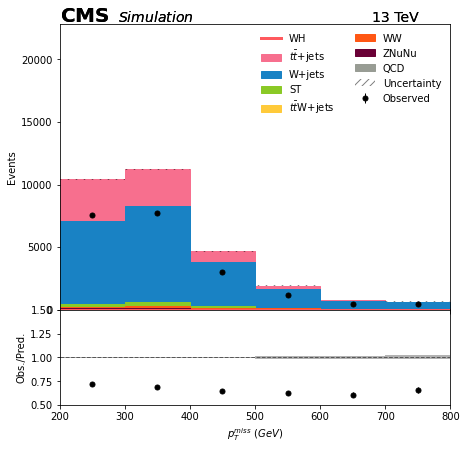

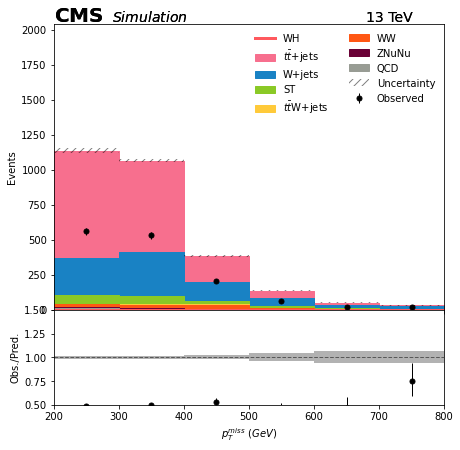

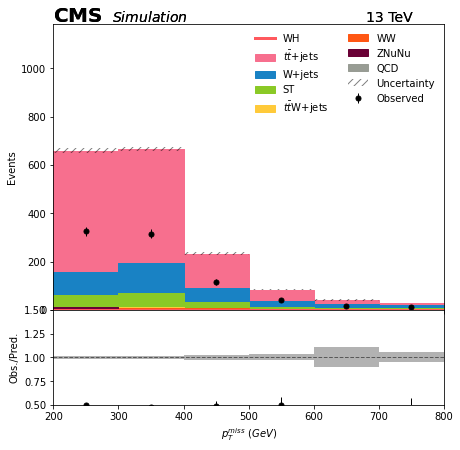

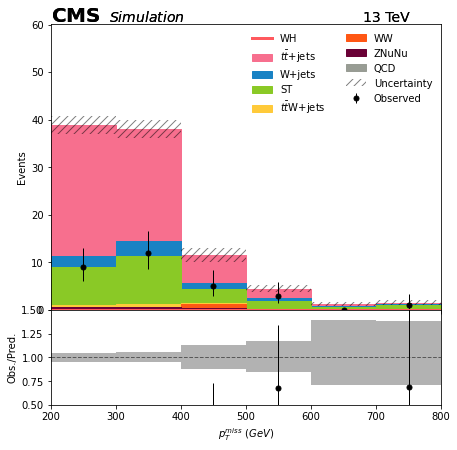

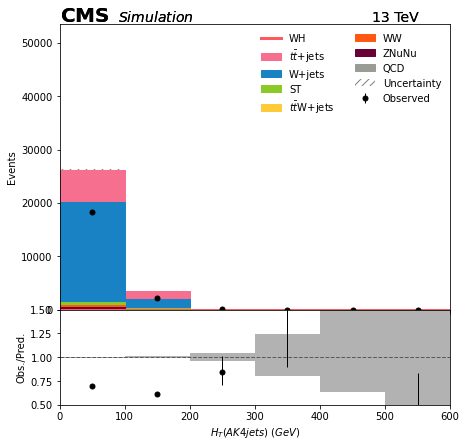

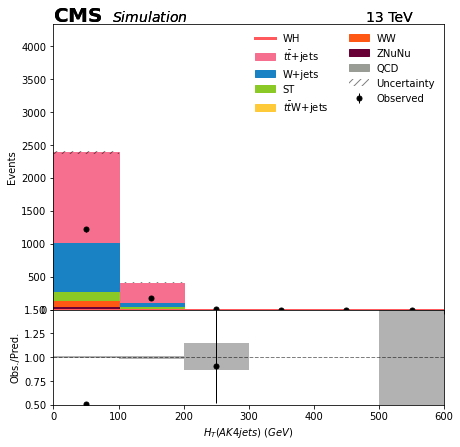

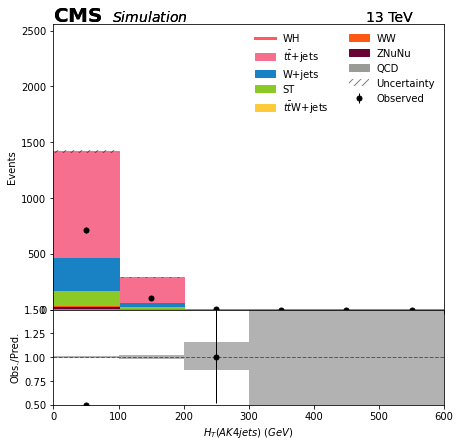

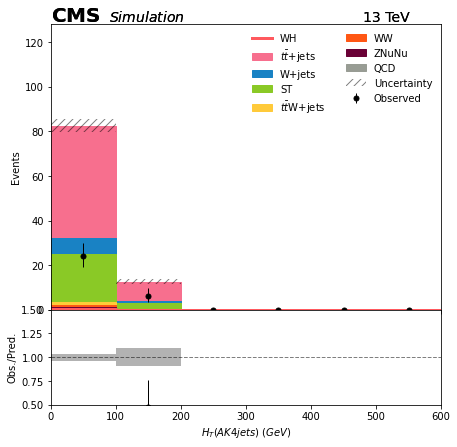

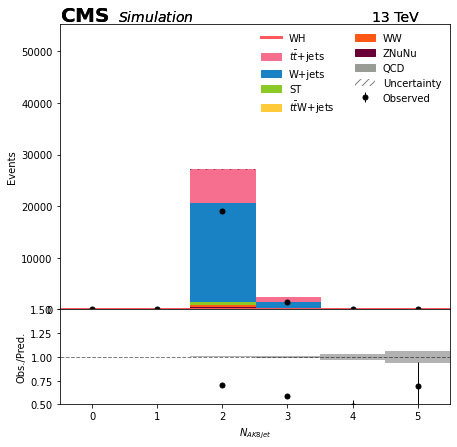

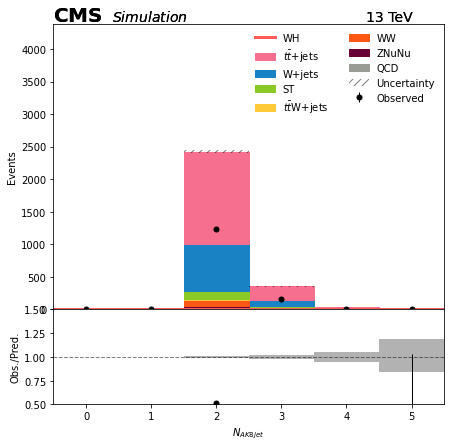

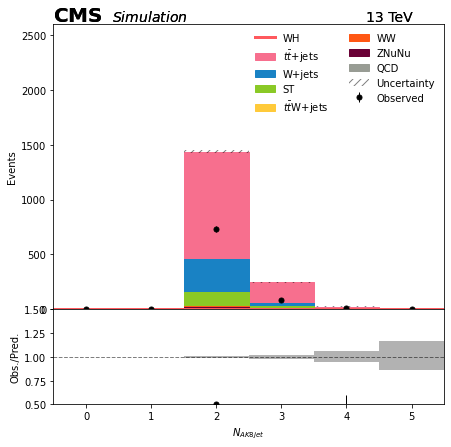

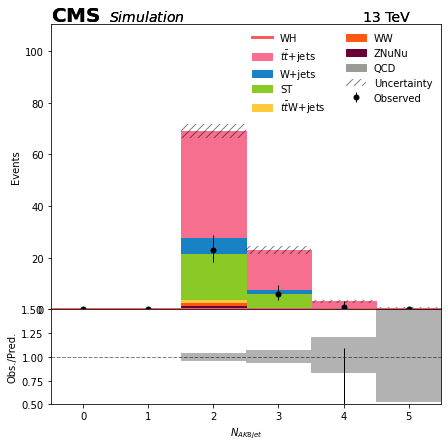

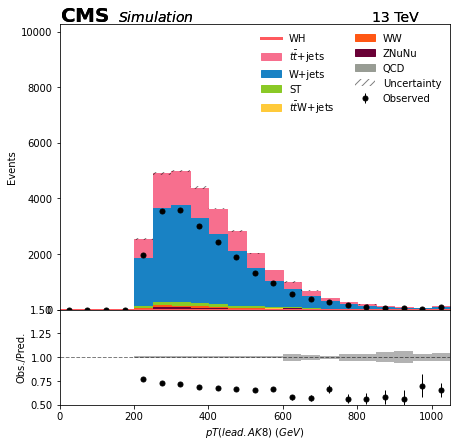

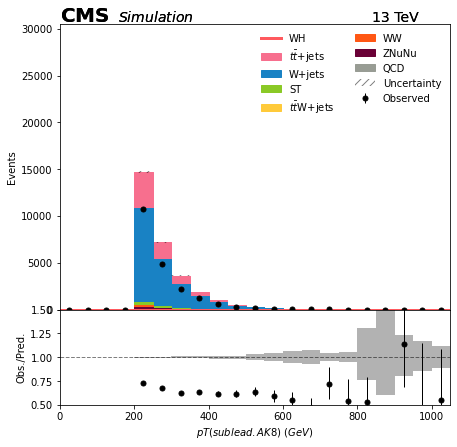

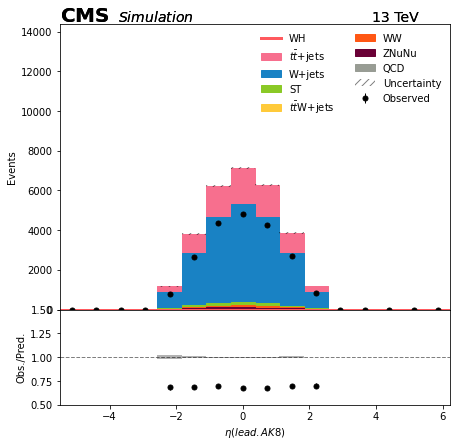

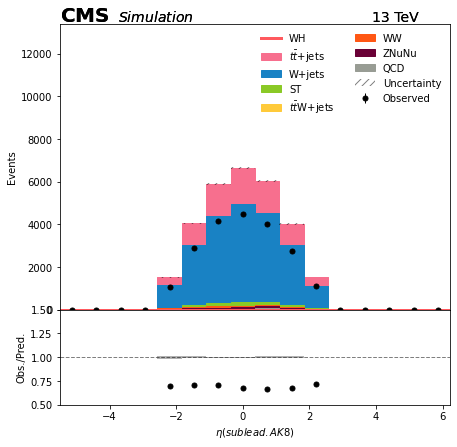

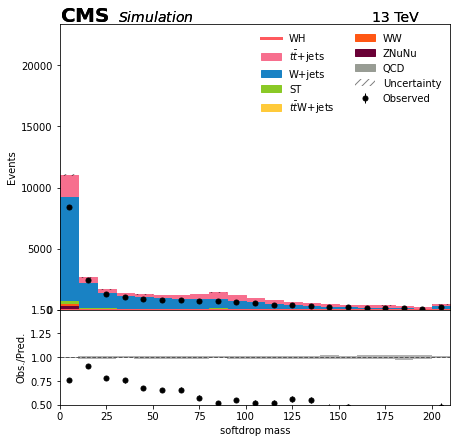

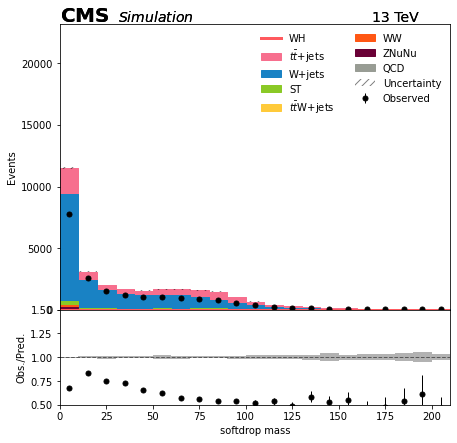

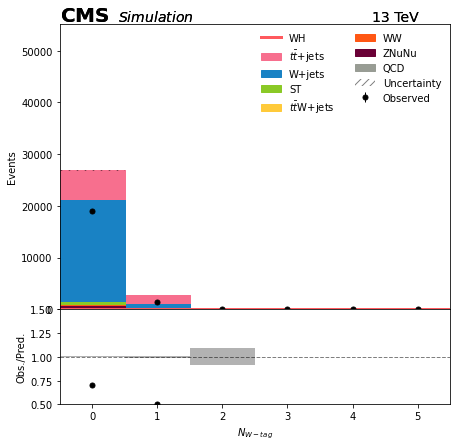

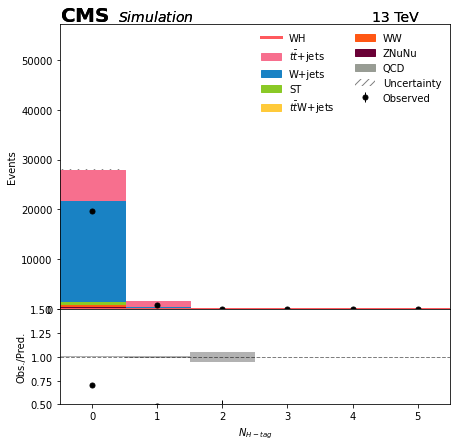

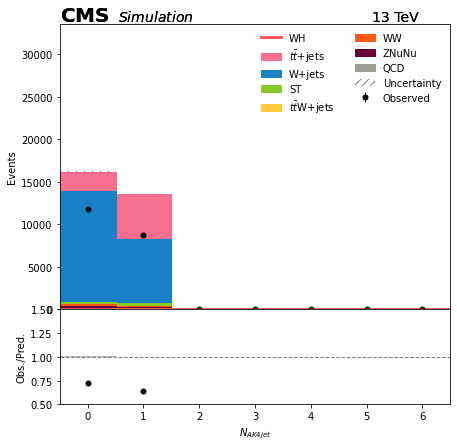

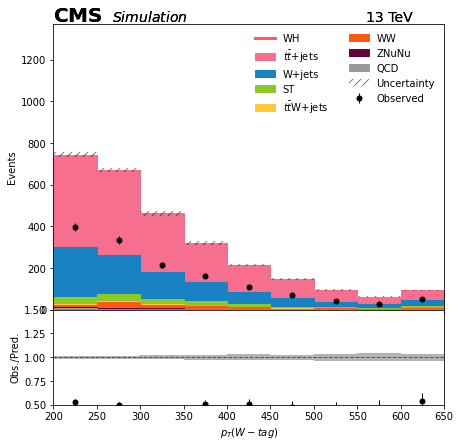

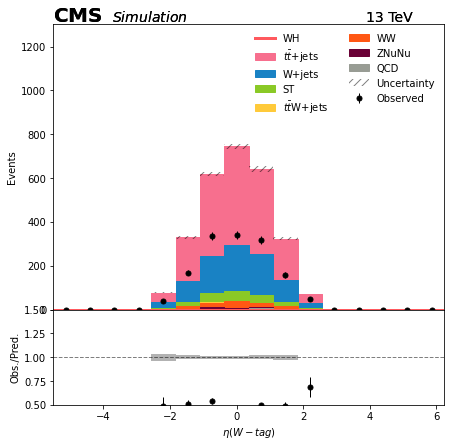

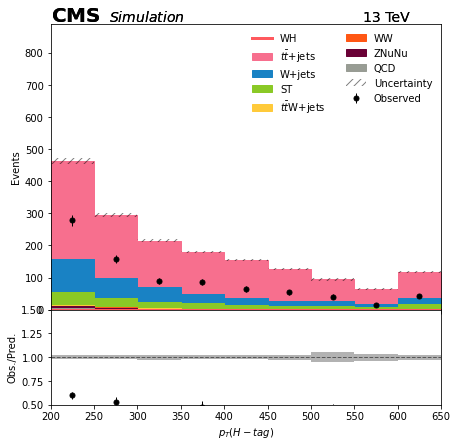

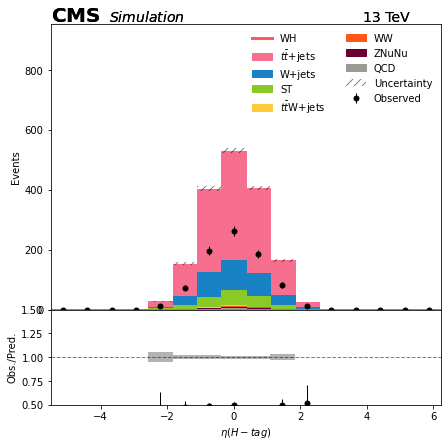

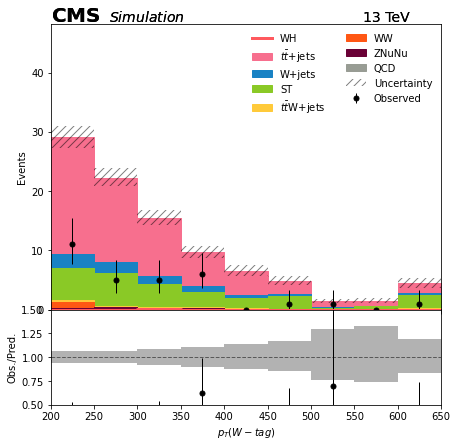

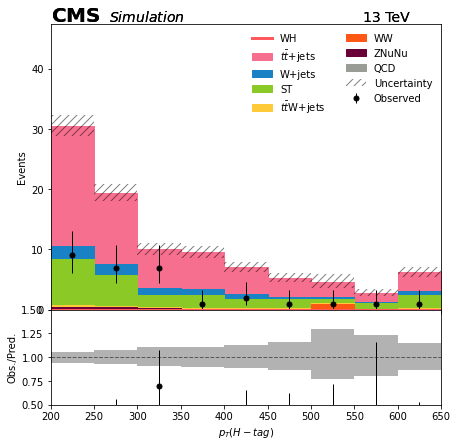

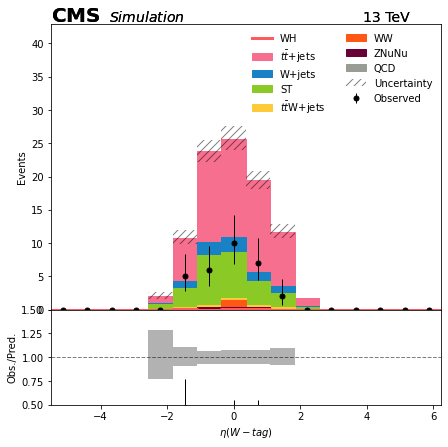

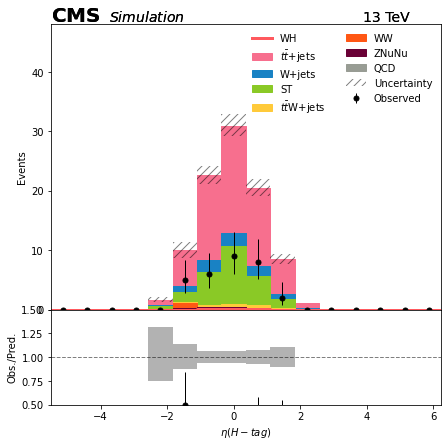

In [15]:
# Make some of the plots

plotDir = '/home/users/ksalyer/public_html/dump/WH_had/'
finalizePlotDir(plotDir)

for plot in histos:

    name = plot[0]
    binName = plot[1]
    histogram = output[name]

    axis = bins[binName]['axis']
    histogram = histogram.rebin(axis, bins[binName]['bins'])

    y_max = histogram.sum("dataset").values(overflow='all')[()].max()
    y_over = histogram.sum("dataset").values(overflow='all')[()][-1]

    import re
    bkganddata = re.compile('(?!mC750_l1)')
    bkgandsig = re.compile('(?!Data)')
    
    background = histogram[bkganddata][bkgandsig]
    signal = histogram['mC750_l1']
    data = histogram['Data']

    #fig, ax = plt.subplots(1,1,figsize=(7,7))
    fig, (ax, rax) = plt.subplots(nrows=2,ncols=1, figsize=(7,7),
        gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
    
    # get axes
    #hist.plot1d(background, overlay="dataset", ax=ax, stack=True, overflow=bins[binName]['overflow'], clear=False, fill_opts=fillopts2, error_opts=error_opts)#, order=['TTJets', 'ST', 'ttW', 'WW', 'ZNuNu', 'QCD', 'WJets']) #error_opts??
    hist.plot1d(background, overlay="dataset", ax=ax, stack=True, overflow=bins[binName]['overflow'], clear=False, fill_opts=fillopts2, error_opts=error_opts, order=['QCD', 'ZNuNu', 'WW', 'ttW', 'ST', 'WJets', 'TTJets']) #error_opts??
    hist.plot1d(signal, overlay="dataset", ax=ax, stack=False, overflow=bins[binName]['overflow'], line_opts=lineopts, clear=False)
    hist.plot1d(data, overlay="dataset", ax=ax, stack=False, overflow=bins[binName]['overflow'], error_opts=data_err_opts_rat, clear=False)

    hist.plotratio(num=data.sum('dataset'), denom=background.sum('dataset'), ax=rax,
                   error_opts = data_err_opts_rat, denom_fill_opts={}, guide_opts={}, 
                   unc='num', overflow = 'over')

    for l in ['log', 'linear']:
        saveFig(fig, ax, rax, plotDir, name, scale=l, shape=False, y_max=y_max)


In [16]:
# Make some of the plots

'''plotDir = '/home/users/ksalyer/public_html/dump/WH_had/'
finalizePlotDir(plotDir)

if True:
    name = 'MET_pt'

    histogram = output['met_CR']

    axis = bins[name]['axis']
    histogram = histogram.rebin(axis, bins[name]['bins'])

    y_max = histogram.sum("dataset").values(overflow='all')[()].max()
    y_over = histogram.sum("dataset").values(overflow='all')[()][-1]

    import re
    bkgonly = re.compile('(?!mC750_l1)')
    notdata = re.compile('(?!pseudodata)')
    notsignal = re.compile('(?!mC750_l1)')

    fig, ax = plt.subplots(1,1,figsize=(7,7))
    
    # get axes
    hist.plot1d(histogram[bkgonly], overlay="dataset", ax=ax, stack=True, overflow=bins[name]['overflow'], clear=False, line_opts=None, fill_opts=fill_opts, error_opts=error_opts)#, order=['QCD', 'ZNuNu', 'LL']) #error_opts??
    hist.plot1d(histogram['mC750_l1'], overlay="dataset", ax=ax, overflow=bins[name]['overflow'], line_opts={'linewidth':3}, clear=False)

    for l in ['log']:
        saveFig(fig, ax, None, plotDir, name, scale=l, shape=False, y_max=y_max)
'''

'plotDir = \'/home/users/ksalyer/public_html/dump/WH_had/\'\nfinalizePlotDir(plotDir)\n\nif True:\n    name = \'MET_pt\'\n\n    histogram = output[\'met_CR\']\n\n    axis = bins[name][\'axis\']\n    histogram = histogram.rebin(axis, bins[name][\'bins\'])\n\n    y_max = histogram.sum("dataset").values(overflow=\'all\')[()].max()\n    y_over = histogram.sum("dataset").values(overflow=\'all\')[()][-1]\n\n    import re\n    bkgonly = re.compile(\'(?!mC750_l1)\')\n    notdata = re.compile(\'(?!pseudodata)\')\n    notsignal = re.compile(\'(?!mC750_l1)\')\n\n    fig, ax = plt.subplots(1,1,figsize=(7,7))\n    \n    # get axes\n    hist.plot1d(histogram[bkgonly], overlay="dataset", ax=ax, stack=True, overflow=bins[name][\'overflow\'], clear=False, line_opts=None, fill_opts=fill_opts, error_opts=error_opts)#, order=[\'QCD\', \'ZNuNu\', \'LL\']) #error_opts??\n    hist.plot1d(histogram[\'mC750_l1\'], overlay="dataset", ax=ax, overflow=bins[name][\'overflow\'], line_opts={\'linewidth\':3}, clear=F

In [17]:
#histogram = output['dphiDiFatJet']
#ax = hist.plot1d(histogram,overlay="dataset", stack=False)

In [18]:
#histogram = output['WH_deltaR']
#ax = hist.plot1d(histogram,overlay="dataset", stack=False)